In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import progressbar

In [2]:
df = pd.read_pickle("../data/sne_light_curves.pkl")
df = df[df.rb >= 0.55]
df = df[df.isdiffpos > 0]
df = df[df.sigmagap < 1.0]
features = ["oid","mjd", "magap", "sigmagap", "fid"]

In [3]:
lcs = []
bar = progressbar.ProgressBar(max_value=len(df.oid.unique()))
bar.start()
for i,oid in enumerate(df.oid.unique()):
    lc = df[df.oid == oid][features]
    for fid in [1]: #,2]:
        lc_fid = lc[lc.fid == fid]
        if len(lc_fid) > 20:
            lc_fid.sort_values('mjd', inplace=True)
            dt = lc_fid.mjd - lc_fid.mjd.min()
#             dt = np.insert(dt, 0, 0, axis=0)
            lc_fid.drop("mjd",axis=1, inplace=True)
            lc_fid["dt"] = dt
            lcs.append(lc_fid)
    bar.update(i+1)

N/A% (0 of 2430) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-3-da024782a457>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lc_fid.sort_values('mjd', inplace=True)
/home/camilo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-3-da024782a457>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [4]:
X_train, X_test = train_test_split(lcs, test_size=0.2,random_state=42)

In [5]:
X_train, X_val = train_test_split(X_train, test_size=0.2,random_state=42)

In [6]:
def prepare_lc(lc):
    dropped_lc = lc.drop("oid",axis=1)
    numpy_lc = dropped_lc[["dt", "magap", "fid"]].to_numpy()
    return [numpy_lc]

In [7]:
def slice_lc(lc):
    sliced_lcs = []
    dropped_lc = lc.drop("oid",axis=1)
    lc = dropped_lc[["dt", "magap", "fid"]]
    if len(lc) > 100: 
        return []
#     return [lc]
    for i in range(13,len(lc)+1):
       lc_tmp = lc[:i]
#        if (lc_tmp.dt > 15).any():
#            continue
       lc_tmp = lc_tmp.to_numpy()
       sliced_lcs.append(lc_tmp)
    return sliced_lcs

In [8]:
sliced_lcs = []
bar = progressbar.ProgressBar(max_value=len(X_train))
bar.start()
for i,lc in enumerate(X_train):
    sliced_lcs.extend(slice_lc(lc))
    bar.update(i+1)

 95% (137 of 144) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00

In [9]:
x_test_prepared = []
bar = progressbar.ProgressBar(max_value=len(X_test))
bar.start()
for i,lc in enumerate(X_test):
    x_test_prepared.extend(slice_lc(lc))
    bar.update(i+1)

 95% (44 of 46) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

In [10]:
x_val_prepared = []
bar = progressbar.ProgressBar(max_value=len(X_val))
bar.start()
for i,lc in enumerate(X_val):
    x_val_prepared.extend(slice_lc(lc))
    bar.update(i+1)

100% (36 of 36) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00

In [11]:
padded_lcs = tf.keras.preprocessing.sequence.pad_sequences(sliced_lcs,dtype="float32", value=-1)

In [12]:
padded_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_prepared,dtype="float32", value=-1)
padded_x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_prepared,dtype="float32", value=-1)

In [13]:
np.save("../data/padded_x_train",padded_lcs)

In [14]:
np.save("../data/padded_x_test",padded_x_test)
np.save("../data/padded_x_val",padded_x_val)

In [15]:
lenghts = [len(l) for l in sliced_lcs]

Text(0.5, 1.05, '$Magnitude [mag]$')

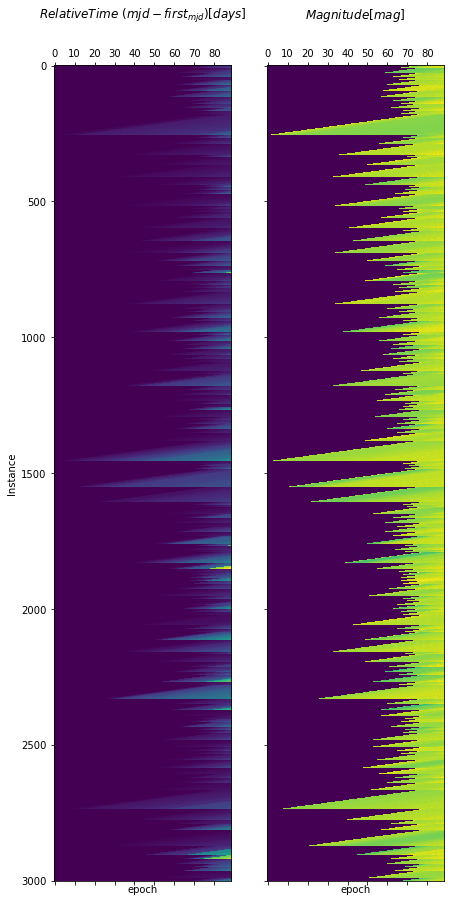

In [16]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(7,15), sharey=True)
axes[0].matshow(padded_lcs[:,:,0], aspect="auto")
axes[1].matshow(padded_lcs[:,:,1], aspect="auto")
axes[0].set_xlabel("epoch")
axes[1].set_xlabel("epoch")
axes[0].set_ylabel("Instance")
axes[0].set_title("$Relative Time \\ (mjd - first_{mjd}) [days]$")
axes[1].set_title("$Magnitude [mag]$")
# plt.colorbar()

In [17]:
lengths = [len(lc) for  lc in sliced_lcs]
lenghts = np.array(lenghts)

(array([1144.,  830.,  399.,  254.,  137.,  101.,   55.,   34.,   29.,
          18.]),
 array([13. , 20.6, 28.2, 35.8, 43.4, 51. , 58.6, 66.2, 73.8, 81.4, 89. ]),
 <a list of 10 Patch objects>)

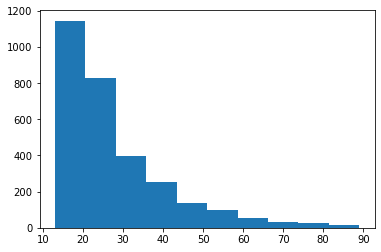

In [18]:
plt.hist(lenghts)

In [19]:
np.sum(lenghts > 50)

237

In [20]:
lenghts.shape

(3001,)